In [1]:
import numpy as np
import torch
import random


SEED = 404
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Analisis Tools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Model package
from darts import TimeSeries
from darts.models import ARIMA

d:\MiniConda\envs\torch_gpu\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
d:\MiniConda\envs\torch_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data preparation

In [3]:
colors = ['#1A73E8', '#34A853', '#FBBC04', '#EA4335', '#9AA0A6']
brands = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

In [4]:
# df = pd.read_csv("../../data/dataCarSale2021-2025.csv")
urlData = "https://raw.githubusercontent.com/zzahranez/otomotive-forecasting/main/data/dataCarSale2021-2025.csv"
df = pd.read_csv(urlData)

In [5]:
print(df.head(15))

        waktu  DAIHATSU    HONDA  MITSUBISHI   SUZUKI   TOYOTA
0    1/1/2021    8993.0   7231.0      9108.0   6400.0  15474.0
1    2/1/2021    9412.0   6812.0      7567.0   4600.0  14645.0
2    3/1/2021   16770.0  11350.0     13088.0   8669.0  26034.0
3    4/1/2021   15861.0   8474.0     13820.0   8100.0  22618.0
4    5/1/2021    8310.0   5832.0     10160.0   5341.0  17361.0
5    6/1/2021   15481.0   8782.0      8277.0   8965.0  22310.0
6    7/1/2021    9284.0   9030.0     13453.0   6274.0  20950.0
7    8/1/2021   14408.0   7337.0     13720.0  10021.0  28418.0
8    9/1/2021   17529.0   3453.0     12200.0   7515.0  32596.0
9   10/1/2021   17020.0   5861.0     13109.0   7624.0  20633.0
10  11/1/2021   16045.0   7201.0     11410.0   8512.0  32487.0
11  12/1/2021   15795.0   9759.0     18211.0   9772.0  31865.0
12   1/1/2022   17660.0  10883.0     14586.0   7017.0  22493.0
13   2/1/2022   14638.0  11407.0     12323.0   6750.0  24087.0
14   3/1/2022   16969.0  12975.0     13299.0   8604.0  

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   waktu       54 non-null     object 
 1   DAIHATSU    54 non-null     float64
 2   HONDA       54 non-null     float64
 3   MITSUBISHI  54 non-null     float64
 4   SUZUKI      54 non-null     float64
 5   TOYOTA      54 non-null     float64
dtypes: float64(5), object(1)
memory usage: 2.7+ KB


##### time have the object type data, in forecasting we must the date data type

In [7]:
df.describe()

,DAIHATSU,HONDA,MITSUBISHI,SUZUKI,TOYOTA
count,54.000000,54.000000,54.000000,54.000000,54.000000
mean,11254.531630,7645.139556,8760.141000,5609.579630,19934.127907
std,4597.871605,3886.261244,3351.676613,2351.526395,7855.556087
min,5755.232000,1590.411000,4349.666000,2004.813000,7617.122000
25%,7477.087250,3855.075250,6204.000000,3227.915000,12472.187250
50%,9310.389000,7725.500000,7637.046000,5830.500000,20983.500000
75%,15638.000000,10809.250000,11669.500000,7514.250000,25945.000000
max,23165.000000,15993.000000,18211.000000,10021.000000,33153.000000


#### a. Convert to datetime

In [8]:
df['waktu'] = pd.to_datetime(df['waktu'], format="%m/%d/%Y")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   waktu       54 non-null     datetime64[ns]
 1   DAIHATSU    54 non-null     float64       
 2   HONDA       54 non-null     float64       
 3   MITSUBISHI  54 non-null     float64       
 4   SUZUKI      54 non-null     float64       
 5   TOYOTA      54 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 2.7 KB


In [10]:
df.set_index('waktu',  inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54 entries, 2021-01-01 to 2025-07-01
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DAIHATSU    54 non-null     float64
 1   HONDA       54 non-null     float64
 2   MITSUBISHI  54 non-null     float64
 3   SUZUKI      54 non-null     float64
 4   TOYOTA      54 non-null     float64
dtypes: float64(5)
memory usage: 2.5 KB


#### b. List Decalartion

In [12]:
colors = ['#00D4AA', '#FF6B9D', '#C44569', '#F8B500', '#6C5CE7']
brands = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

#### c. Missing value

In [13]:
df.isna().sum()

DAIHATSU      0
HONDA         0
MITSUBISHI    0
SUZUKI        0
TOYOTA        0
dtype: int64

In [14]:
print(df[33:40])

            DAIHATSU      HONDA  MITSUBISHI  SUZUKI     TOYOTA
waktu                                                         
2023-10-01  8208.000  11307.000    6690.000  5502.0  21298.000
2023-11-01  7466.000  10307.000    6600.000  6602.0  24622.000
2024-01-01  7348.196   3222.119    5076.613  3242.0  10366.353
2024-02-01  6021.329   3829.318    4349.666  2999.0  10770.845
2024-03-01  6591.920   5212.549    4708.298  3503.0  12301.583
2024-04-01  7510.349   3435.000    4898.000  2555.0   9116.144
2024-05-01  9336.778   5055.000    5522.211  2736.0   9445.956


#### d. Handling Missing Value

In [15]:
all_months = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')

In [16]:
print(all_months)

DatetimeIndex(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',
               '2025-05-01', '2025-06-01', '2025-07-01'],
              dtype

In [17]:
# Reindexs
df = df.reindex(all_months)

In [18]:
df.isna().sum()

DAIHATSU      1
HONDA         1
MITSUBISHI    1
SUZUKI        1
TOYOTA        1
dtype: int64

In [19]:
df = df.interpolate(method='linear')

In [20]:
print("Setelah Imputasi : ")
df.isna().sum()

Setelah Imputasi : 


DAIHATSU      0
HONDA         0
MITSUBISHI    0
SUZUKI        0
TOYOTA        0
dtype: int64

In [21]:
print(df[35:40])

            DAIHATSU      HONDA  MITSUBISHI  SUZUKI      TOYOTA
2023-12-01  7407.098  6764.5595   5838.3065  4922.0  17494.1765
2024-01-01  7348.196  3222.1190   5076.6130  3242.0  10366.3530
2024-02-01  6021.329  3829.3180   4349.6660  2999.0  10770.8450
2024-03-01  6591.920  5212.5490   4708.2980  3503.0  12301.5830
2024-04-01  7510.349  3435.0000   4898.0000  2555.0   9116.1440


#### c.Data Visualization

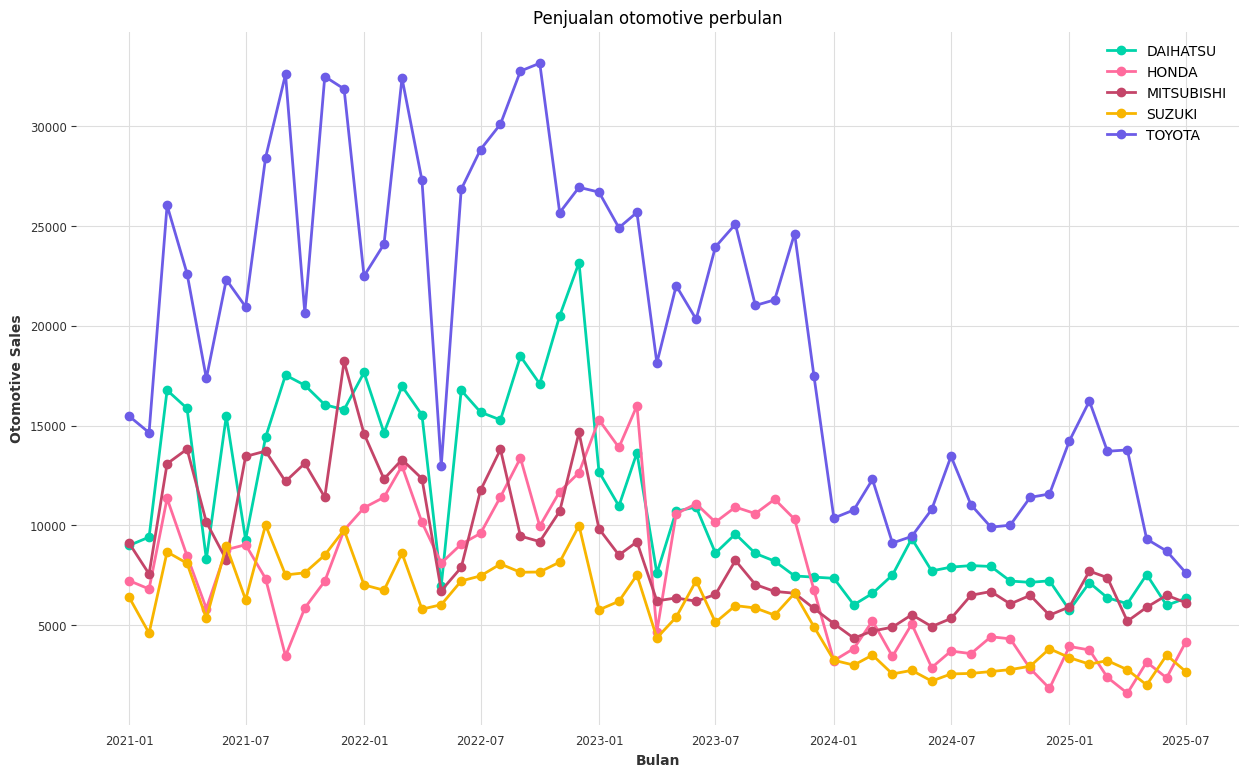

In [22]:
plt.figure(figsize=(15,9))
for i, brand in enumerate(brands):
    plt.plot(df.index, df[brand], marker='o', color=colors[i], label=brand, linewidth=2.0)
plt.title('Penjualan otomotive perbulan')
plt.xlabel('Bulan')
plt.ylabel('Otomotive Sales')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
for brand in brands:
    df[brand] = df[brand].round(0)

## 2. Uji Seasonal

#### a. With Plot

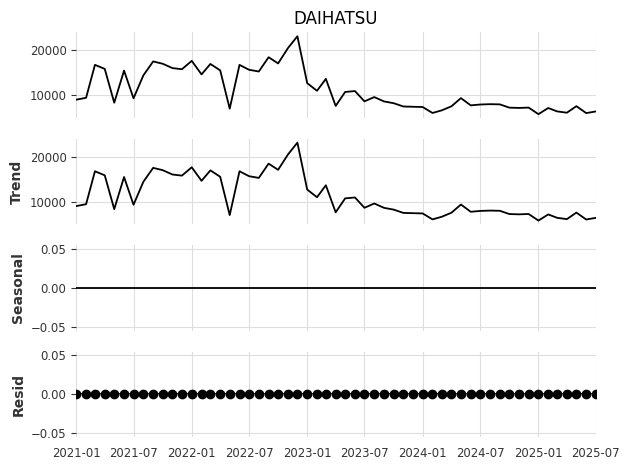

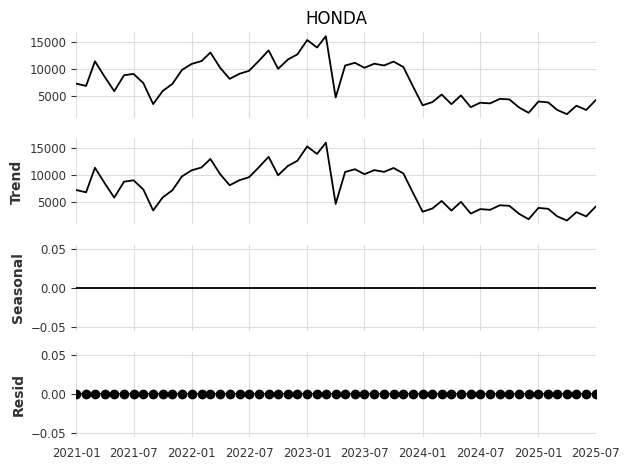

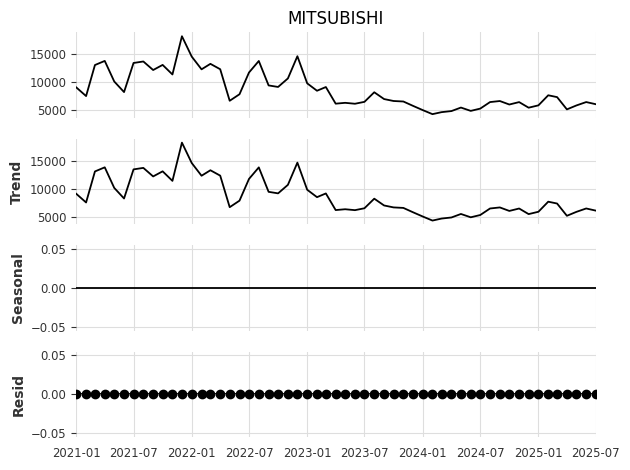

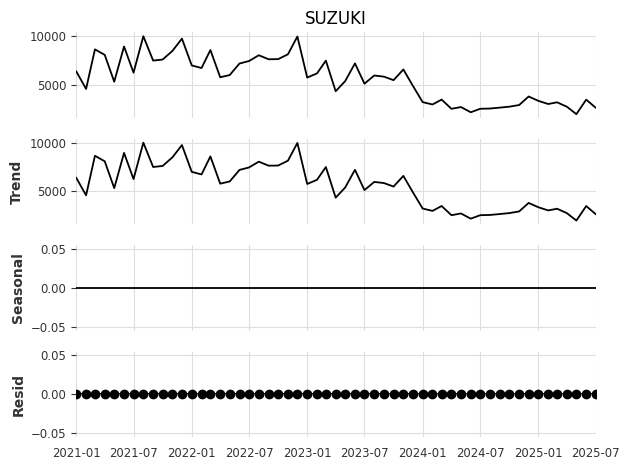

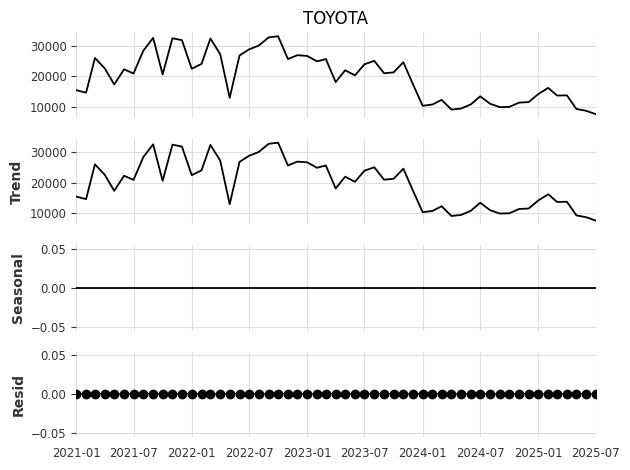

In [24]:
for i, brand in enumerate(brands):
    result = seasonal_decompose(df[brand], model='additive', period=1)
    result.plot()
    plt.show()

## 3. Uji Stasioneritas And Handle Data Has Not Stasioners

#### a. Augmentation DickeyFuller

##### Forecasting harus menggunakan model yang stasioner jika data tidak stasioner maka, di differencing

In [25]:
def adf_test(timeseries, name=""):
    print(f"=== ADF Test for {name} ===")
    print("==============================")
    
    result = adfuller(timeseries.dropna())
    
    hasil_adf = pd.Series(result[0:4], 
                          index=["Test Statistic", "p-value", "Lags Used", "Number of Observations Used"])
    
    for key, value in result[4].items():
        hasil_adf[f"Critical Value ({key})"] = value
    
    print(hasil_adf, "\n")
    
    if result[1] <= 0.05:
        print("✅ Data stasioner (tolak H0)\n")
    else:
        print("❌ Data tidak stasioner (gagal tolak H0)\n")


In [26]:
for brand in brands:
    adf_test(df[brand], name=brand)

=== ADF Test for DAIHATSU ===
Test Statistic                 -0.994295
p-value                         0.755339
Lags Used                       4.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64 

❌ Data tidak stasioner (gagal tolak H0)

=== ADF Test for HONDA ===
Test Statistic                 -1.748192
p-value                         0.406469
Lags Used                       1.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64 

❌ Data tidak stasioner (gagal tolak H0)

=== ADF Test for MITSUBISHI ===
Test Statistic                 -1.324532
p-value                         0.617875
Lags Used                       2.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (

##### Dari hasil pengujian dickyfuller dapat diambil kesimpulan kalau sanya data tidak stasioner, maka data harus melewati proses differencing terlebih dahulu sebelum masuk ke pelatihan

#### b. Differencing 1

In [27]:
print(df.tail(3))

            DAIHATSU   HONDA  MITSUBISHI  SUZUKI  TOYOTA
2025-05-01    7538.0  3148.0      5897.0  2005.0  9313.0
2025-06-01    5992.0  2361.0      6501.0  3499.0  8712.0
2025-07-01    6354.0  4171.0      6121.0  2666.0  7617.0


In [28]:
df_diff = df.copy()

In [29]:
df_diff = df_diff.diff().dropna()

In [30]:
print(df_diff.head(15))

            DAIHATSU   HONDA  MITSUBISHI  SUZUKI   TOYOTA
2021-02-01     419.0  -419.0     -1541.0 -1800.0   -829.0
2021-03-01    7358.0  4538.0      5521.0  4069.0  11389.0
2021-04-01    -909.0 -2876.0       732.0  -569.0  -3416.0
2021-05-01   -7551.0 -2642.0     -3660.0 -2759.0  -5257.0
2021-06-01    7171.0  2950.0     -1883.0  3624.0   4949.0
2021-07-01   -6197.0   248.0      5176.0 -2691.0  -1360.0
2021-08-01    5124.0 -1693.0       267.0  3747.0   7468.0
2021-09-01    3121.0 -3884.0     -1520.0 -2506.0   4178.0
2021-10-01    -509.0  2408.0       909.0   109.0 -11963.0
2021-11-01    -975.0  1340.0     -1699.0   888.0  11854.0
2021-12-01    -250.0  2558.0      6801.0  1260.0   -622.0
2022-01-01    1865.0  1124.0     -3625.0 -2755.0  -9372.0
2022-02-01   -3022.0   524.0     -2263.0  -267.0   1594.0
2022-03-01    2331.0  1568.0       976.0  1854.0   8321.0
2022-04-01   -1436.0 -2826.0      -959.0 -2803.0  -5124.0


#### a. result

In [31]:
print(df.head())

            DAIHATSU    HONDA  MITSUBISHI  SUZUKI   TOYOTA
2021-01-01    8993.0   7231.0      9108.0  6400.0  15474.0
2021-02-01    9412.0   6812.0      7567.0  4600.0  14645.0
2021-03-01   16770.0  11350.0     13088.0  8669.0  26034.0
2021-04-01   15861.0   8474.0     13820.0  8100.0  22618.0
2021-05-01    8310.0   5832.0     10160.0  5341.0  17361.0


In [32]:
print(df_diff.head())

            DAIHATSU   HONDA  MITSUBISHI  SUZUKI   TOYOTA
2021-02-01     419.0  -419.0     -1541.0 -1800.0   -829.0
2021-03-01    7358.0  4538.0      5521.0  4069.0  11389.0
2021-04-01    -909.0 -2876.0       732.0  -569.0  -3416.0
2021-05-01   -7551.0 -2642.0     -3660.0 -2759.0  -5257.0
2021-06-01    7171.0  2950.0     -1883.0  3624.0   4949.0


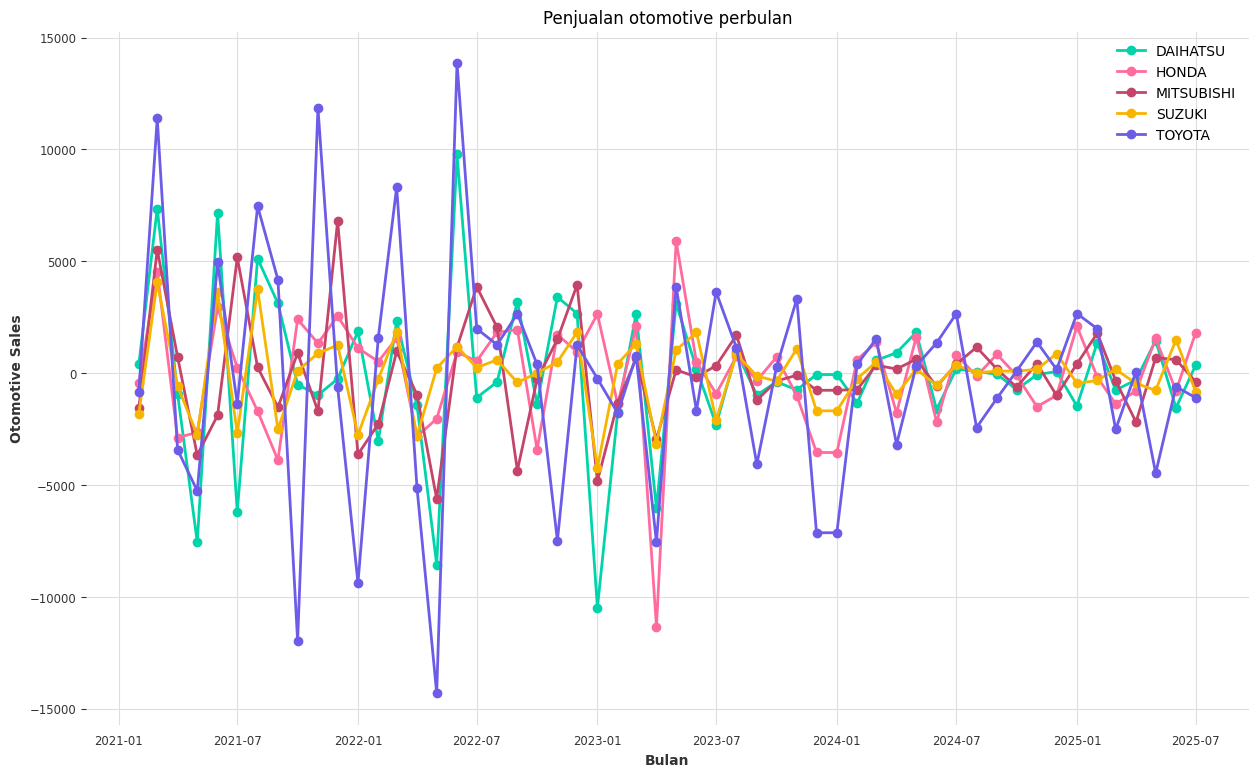

In [33]:
plt.figure(figsize=(15,9))
for i, brand in enumerate(brands):
    plt.plot(df_diff.index, df_diff[brand], marker='o', color=colors[i], label=brand, linewidth=2.0)
plt.title('Penjualan otomotive perbulan')
plt.xlabel('Bulan')
plt.ylabel('Otomotive Sales')
plt.grid(True)
plt.legend()
plt.show()

In [34]:
for brand in brands:
    adf_test(df_diff[brand], name=brand)

=== ADF Test for DAIHATSU ===
Test Statistic                 -4.397963
p-value                         0.000299
Lags Used                       3.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64 

✅ Data stasioner (tolak H0)

=== ADF Test for HONDA ===
Test Statistic                -9.751092e+00
p-value                        8.012230e-17
Lags Used                      0.000000e+00
Number of Observations Used    5.300000e+01
Critical Value (1%)           -3.560242e+00
Critical Value (5%)           -2.917850e+00
Critical Value (10%)          -2.596796e+00
dtype: float64 

✅ Data stasioner (tolak H0)

=== ADF Test for MITSUBISHI ===
Test Statistic                 -2.380058
p-value                         0.147444
Lags Used                      11.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)

## 4. Mencari Nilai Orde d dan q

<Figure size 1200x600 with 0 Axes>

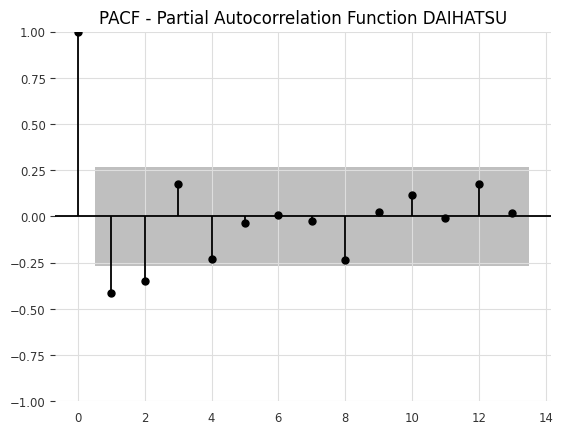

<Figure size 1200x600 with 0 Axes>

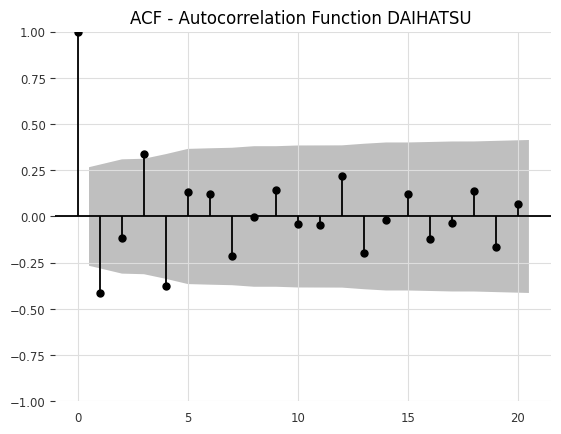

<Figure size 1200x600 with 0 Axes>

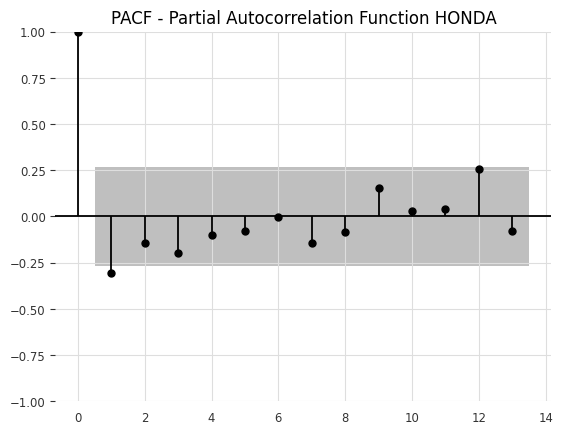

<Figure size 1200x600 with 0 Axes>

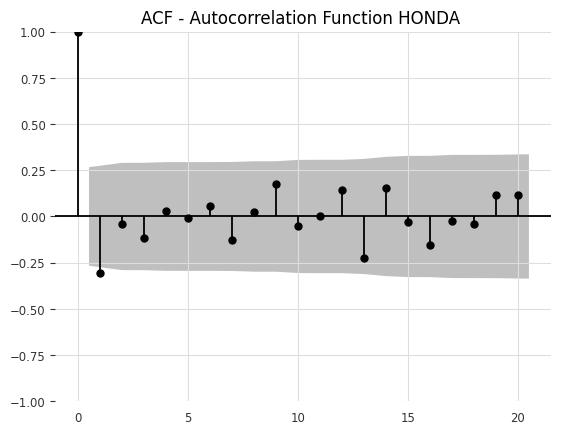

<Figure size 1200x600 with 0 Axes>

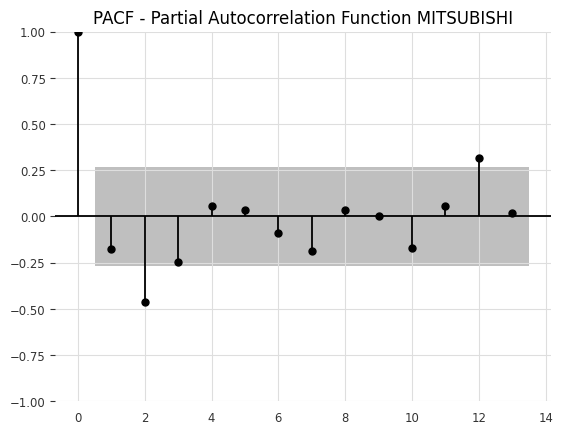

<Figure size 1200x600 with 0 Axes>

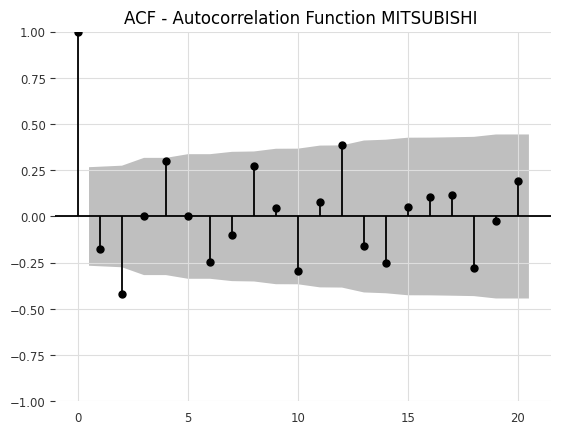

<Figure size 1200x600 with 0 Axes>

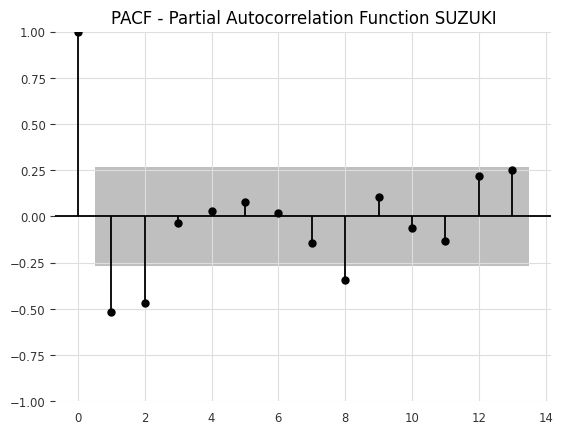

<Figure size 1200x600 with 0 Axes>

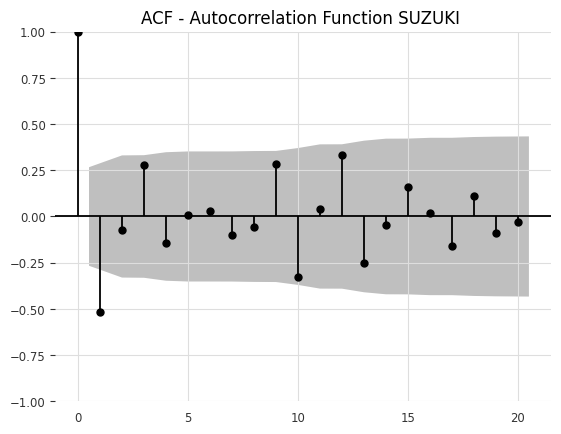

<Figure size 1200x600 with 0 Axes>

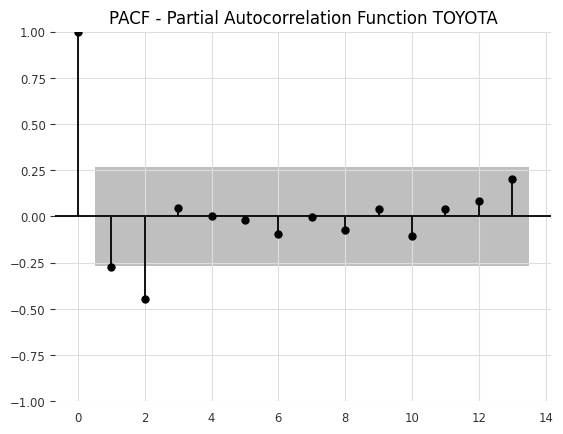

<Figure size 1200x600 with 0 Axes>

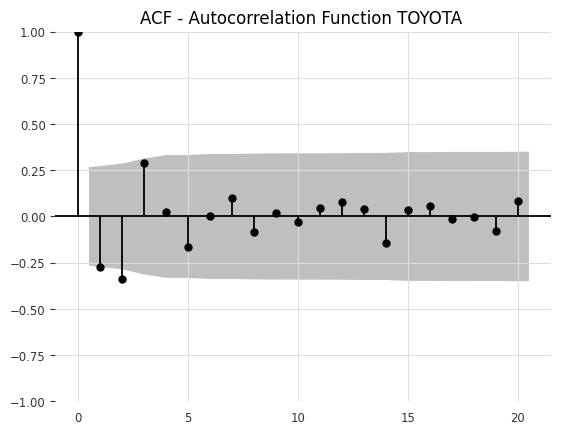

In [35]:
for brand in brands:
    plt.figure(figsize=(12, 6))
    plot_pacf(df_diff[brand], lags=13)    
    plt.title(f'PACF - Partial Autocorrelation Function {brand}')
    plt.show()

    plt.figure(figsize=(12, 6))
    plot_acf(df_diff[brand], lags=20)
    plt.title(f'ACF - Autocorrelation Function {brand} ')
    plt.show()

##### Dari hasil plot autocorrelation dan plot partial autocorrelation function dapat dilihat kalau orde untuk p dan q adalah 1 lag signifikan yang melewati ambang batas dan lag setelah lag 1 dan 2 itu mendekati 0 yangg menujukan kalau nilai autokorelasi setelah nya tidak signifkan

## Modelling 

In [36]:
from darts.metrics import smape

In [37]:
print(df.head(1))

            DAIHATSU   HONDA  MITSUBISHI  SUZUKI   TOYOTA
2021-01-01    8993.0  7231.0      9108.0  6400.0  15474.0


In [38]:
def backtesting(p,d,q,seriesset):
    model = ARIMA(p, d, q)

    backtest_forecast = model.backtest(
    series=seriesset,      
    start=0.8,               
    forecast_horizon=1,     
    metric=smape,            
    verbose=False
    )
    print(f"Rata-rata sMAPE backtesting: {backtest_forecast:.2f}%")

#### 1. Daihatsu

In [39]:
ts_Daihatsu = TimeSeries.from_series(
    df['DAIHATSU'],
    fill_missing_dates=True,
    freq=None
)

# Split Data To Testing
horizon = 6
# train, test = ts_Daihatsu[:-6], ts_Daihatsu[-6:]
train, test = ts_Daihatsu[:-1], ts_Daihatsu[-1:]

In [40]:
print("Train Data\n",df['DAIHATSU'][40:-1])
print("Testing data : ",df['DAIHATSU'][-1:])

Train Data
 2024-05-01    9337.0
2024-06-01    7717.0
2024-07-01    7908.0
2024-08-01    7985.0
2024-09-01    7941.0
2024-10-01    7210.0
2024-11-01    7145.0
2024-12-01    7222.0
2025-01-01    5755.0
2025-02-01    7127.0
2025-03-01    6372.0
2025-04-01    6076.0
2025-05-01    7538.0
2025-06-01    5992.0
Freq: MS, Name: DAIHATSU, dtype: float64
Testing data :  2025-07-01    6354.0
Freq: MS, Name: DAIHATSU, dtype: float64


In [41]:
model_arima = ARIMA(2,1,2)
model_arima.fit(train)

forecast_july = model_arima.predict(1)

# Perform Accuracy with sMape
july_smape = smape(test, forecast_july)
accuracy = 100 - july_smape

print("   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---")
print(f"sMAPE untuk Juli 2025: {july_smape:.2f}%")
print(f"Accurayy : {accuracy:.2f}%")
# Compare Accuracy 
print("Nilai aktual Juli 2025 :", test.values()[0][0])
print("Forecast Juli 2025     :", forecast_july.values()[0][0])

print("\n", "-"*50)
print(f"\t---> PREDIKSI UTAMA {brands[0]} <---")

# ---> Re Train for count full data until july 2025
arima_model_full = ARIMA(2, 1, 2)
arima_model_full.fit(ts_Daihatsu)

forecast_august = arima_model_full.predict(1)
print("Prediksi Agustus 2025 :", forecast_august.values()[0][0])


# Convert forecast ke pandas Series (nilai asli, tidak differenced)
forecast_august = arima_model_full.predict(1)  # Forecast level

   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---
sMAPE untuk Juli 2025: 3.16%
Accurayy : 96.84%
Nilai aktual Juli 2025 : 6354.0
Forecast Juli 2025     : 6558.086708254465

 --------------------------------------------------
	---> PREDIKSI UTAMA DAIHATSU <---
Prediksi Agustus 2025 : 6577.133121685332


d:\MiniConda\envs\torch_gpu\Lib\site-packages\darts\timeseries.py:4491: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  p = ax.plot(
d:\MiniConda\envs\torch_gpu\Lib\site-packages\darts\timeseries.py:4491: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  p = ax.plot(


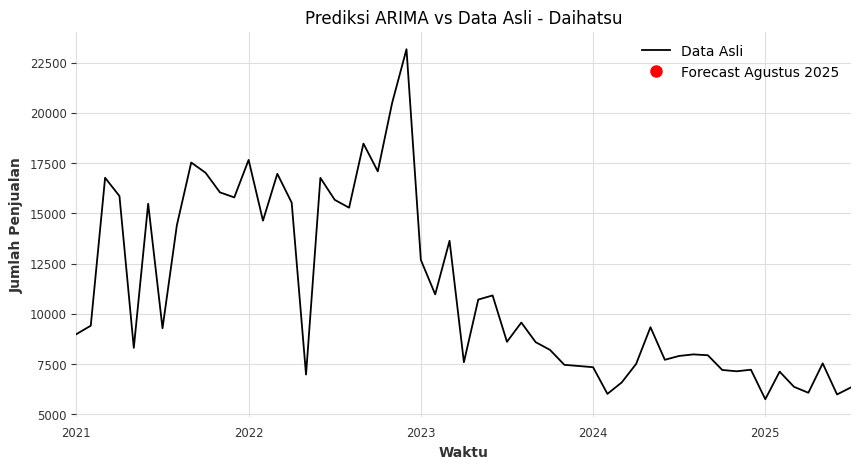

In [42]:
df['DAIHATSU'].plot(label='Data Asli', figsize=(10,5))
forecast_august.plot(label='Forecast Agustus 2025', color='red', marker='o', markersize=8)

plt.title("Prediksi ARIMA vs Data Asli - Daihatsu")
plt.xlabel("Waktu")
plt.ylabel("Jumlah Penjualan")
plt.legend()
plt.show()


#### 2. Honda

In [43]:
ts_Honda = TimeSeries.from_series(
    df['HONDA'],
    fill_missing_dates=True,
    freq=None
)

# Split Data To Testing
horizon = 6
# train, test = ts_Honda[:-6], ts_Honda[-6:]
train, test = ts_Honda[:-1], ts_Honda[-1:]

In [44]:
model_arima = ARIMA(3,1,6)
model_arima.fit(train)

forecast_july = model_arima.predict(1)

# Perform Accuracy with sMape
july_smape = smape(test, forecast_july)
accuracy = 100 - july_smape

print("   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---")
print(f"sMAPE untuk Juli 2025: {july_smape:.2f}%")
print(f"Accurayy : {accuracy:.2f}%")
# Compare Accuracy 
print("Nilai aktual Juli 2025 :", test.values()[0][0])
print("Forecast Juli 2025     :", forecast_july.values()[0][0])

print("\n", "-"*50)
print(f"\t---> PREDIKSI UTAMA {brands[1]} <---")

# ---> Re Train for count full data until july 2025
arima_model_full = ARIMA(3, 1, 6)
arima_model_full.fit(ts_Honda)

forecast_august = arima_model_full.predict(1)
print("Prediksi Agustus 2025 :", forecast_august.values()[0][0])


# Convert forecast ke pandas Series (nilai asli, tidak differenced)
forecast_august = arima_model_full.predict(1)  # Forecast level

d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---
sMAPE untuk Juli 2025: 20.39%
Accurayy : 79.61%
Nilai aktual Juli 2025 : 4171.0
Forecast Juli 2025     : 5118.012236724133

 --------------------------------------------------
	---> PREDIKSI UTAMA HONDA <---
Prediksi Agustus 2025 : 3527.032667554663


d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
print(df['HONDA'].tail(2))

2025-06-01    2361.0
2025-07-01    4171.0
Freq: MS, Name: HONDA, dtype: float64


#### 3. MITSUBISHI

In [46]:
ts_mitsubishi = TimeSeries.from_series(
    df['MITSUBISHI'],
    fill_missing_dates=True,
    freq=None
)

# Split Data To Testing
horizon = 6
# train, test = ts_Honda[:-6], ts_Honda[-6:]
train, test = ts_mitsubishi[:-1], ts_mitsubishi[-1:]

In [47]:
model_arima = ARIMA(3,1,0)
model_arima.fit(train)

forecast_july = model_arima.predict(1)

# Perform Accuracy with sMape
july_smape = smape(test, forecast_july)
accuracy = 100 - july_smape

print("   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---")
print(f"sMAPE untuk Juli 2025: {july_smape:.2f}%")
print(f"Accurayy : {accuracy:.2f}%")
# Compare Accuracy 
print("Nilai aktual Juli 2025 :", test.values()[0][0])
print("Forecast Juli 2025     :", forecast_july.values()[0][0])

print("\n", "-"*50)
print(f"\t---> PREDIKSI UTAMA {brands[2]} <---")

# ---> Re Train for count full data until july to predict august 2025
arima_model_full = ARIMA(3,1,0)
arima_model_full.fit(ts_mitsubishi)

forecast_august = arima_model_full.predict(1)
print("Prediksi Agustus 2025 :", forecast_august.values()[0][0])


# Convert forecast ke pandas Series (nilai asli, tidak differenced)
forecast_august = arima_model_full.predict(1)  # Forecast level

   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---
sMAPE untuk Juli 2025: 5.04%
Accurayy : 94.96%
Nilai aktual Juli 2025 : 6121.0
Forecast Juli 2025     : 6437.771718859773

 --------------------------------------------------
	---> PREDIKSI UTAMA MITSUBISHI <---
Prediksi Agustus 2025 : 5938.383492402302


#### 4. SUZUKI

In [48]:
ts_suzuki = TimeSeries.from_series(
    df['SUZUKI'],
    fill_missing_dates=True,
    freq=None
)

# Split Data To Testing
horizon = 6
# train, test = ts_Honda[:-6], ts_Honda[-6:]
train, test = ts_suzuki[:-1], ts_suzuki[-1:]

In [49]:
model_arima = ARIMA(2,1,1)
model_arima.fit(train)

forecast_july = model_arima.predict(1)

# Perform Accuracy with sMape
july_smape = smape(test, forecast_july)
accuracy = 100 - july_smape

print("   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---")
print(f"sMAPE untuk Juli 2025: {july_smape:.2f}%")
print(f"Accurayy : {accuracy:.2f}%")
# Compare Accuracy 
print("Nilai aktual Juli 2025 :", test.values()[0][0])
print("Forecast Juli 2025     :", forecast_july.values()[0][0])

print("\n", "-"*50)
print(f"\t---> PREDIKSI UTAMA {brands[3]} <---")

# ---> Re Train for count full data until july 2025
arima_model_full = ARIMA(2,1,1)
arima_model_full.fit(ts_suzuki)

forecast_august = arima_model_full.predict(1)
print("Prediksi Agustus 2025 :", forecast_august.values()[0][0])


# Convert forecast ke pandas Series (nilai asli, tidak differenced)
forecast_august = arima_model_full.predict(1)  # Forecast level

   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---
sMAPE untuk Juli 2025: 3.98%
Accurayy : 96.02%
Nilai aktual Juli 2025 : 2666.0
Forecast Juli 2025     : 2774.2717612267293

 --------------------------------------------------
	---> PREDIKSI UTAMA SUZUKI <---
Prediksi Agustus 2025 : 2850.971577843176


#### 5. TOYOTA

In [50]:
ts_toyota = TimeSeries.from_series(
    df['TOYOTA'],
    fill_missing_dates=True,
    freq=None
)

# Split Data To Testing
horizon = 6
# train, test = ts_Honda[:-6], ts_Honda[-6:]
train, test = ts_toyota[:-1], ts_toyota[-1:]

In [51]:
model_arima = ARIMA(4,1,6)
model_arima.fit(train)

forecast_july = model_arima.predict(1)

# Perform Accuracy with sMape
july_smape = smape(test, forecast_july)
accuracy = 100 - july_smape

print("   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---")
print(f"sMAPE untuk Juli 2025: {july_smape:.2f}%")
print(f"Accurayy : {accuracy:.2f}%")
# Compare Accuracy 
print("Nilai aktual Juli 2025 :", test.values()[0][0])
print("Forecast Juli 2025     :", forecast_july.values()[0][0])

print("\n", "-"*50)
print("\t---> PREDIKSI UTAMA <---")

# ---> Re Train for count full data until july 2025
arima_model_full = ARIMA(4, 1, 6)
arima_model_full.fit(ts_toyota)

forecast_august = arima_model_full.predict(1)
print("Prediksi Agustus 2025 :", forecast_august.values()[0][0])


d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---
sMAPE untuk Juli 2025: 9.39%
Accurayy : 90.61%
Nilai aktual Juli 2025 : 7617.0
Forecast Juli 2025     : 8367.482360826361

 --------------------------------------------------
	---> PREDIKSI UTAMA <---
Prediksi Agustus 2025 : 9340.547545992027


d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [52]:
backtesting(2,1,2,ts_Daihatsu)
backtesting(3,1,0,ts_mitsubishi)
backtesting(2,1,1, ts_suzuki)
# backtesting(4,1,6,ts_toyota)

Rata-rata sMAPE backtesting: 8.00%
Rata-rata sMAPE backtesting: 10.28%
Rata-rata sMAPE backtesting: 13.76%


In [53]:
backtesting(3,1,6, ts_Honda)

d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmo

Rata-rata sMAPE backtesting: 41.97%


d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
backtesting(4,1,6, ts_toyota)

d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: Convergence

Rata-rata sMAPE backtesting: 18.75%


d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
